In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pickle

from IPython.display import set_matplotlib_formats
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from ASTROMER.models import SingleBandEncoder
from ASTROMER.preprocessing import make_pretraining
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, LSTM
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

sys.path.append('..')
from env_config import DATA_PATH, PROJECT_PATH
from utils import average_nights

In [3]:
%matplotlib inline
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
sns.set_style('ticks', {'axes.grid': False})
pd.set_option('mode.chained_assignment', None)

/tmp/ipykernel_4083734/2291959376.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [5]:
filter = 'g'

# Prepare lightcurves

In [5]:
# This is actually not needed, all experiments should be done on the same data,
# hence, data with available features, to make justful comparison between RF and astromer.
# But, final astromer model can be trained on more data.

In [6]:
# Read ZTF x SDSS
with open(os.path.join(DATA_PATH, 'ZTF_x_SDSS/ztf_20210401_x_specObj-dr18__singles_filter_{}'.format(filter)), 'rb') as file:
    ztf_x_sdss = np.array(pickle.load(file))

In [ ]:
# Create lightcurves with reduced deep drilling
ztf_x_sdss_reduced = [average_nights(lc_dict) for lc_dict in tqdm(ztf_x_sdss)]

  0%|          | 0/451462 [00:00<?, ?it/s]

In [ ]:
# Get objects with n_obs > 20
ztf_x_sdss_reduced_obs = [lc_dict for lc_dict in tqdm(ztf_x_sdss_reduced) if len(lc_dict['mjd']) >= 20]

In [10]:
# Save reduced
file_path = 'ZTF_x_SDSS/ztf_20210401_x_specObj-dr18__singles_filter_{}__lc_reduced'
fp = file_path.format(filter)
with open(os.path.join(DATA_PATH, fp), 'wb') as file:
    pickle.dump(ztf_x_sdss_reduced_obs, file)

# Read data

In [6]:
file_path = 'ZTF_x_SDSS/ztf_20210401_x_specObj-dr18__singles_filter_{}__features_lc_reduced'.format(filter)
with open(os.path.join(DATA_PATH, file_path), 'rb') as file:
    ztf_x_sdss_reduced = pickle.load(file)

In [7]:
# Change shape to feed a neural network
X = [np.array([np.array([lc_dict['mjd'][i], lc_dict['mag'][i], lc_dict['magerr'][i]], dtype='object') for i in range(len(lc_dict['mjd']))], dtype='object') for lc_dict in tqdm(ztf_x_sdss_reduced)]

  0%|          | 0/321929 [00:00<?, ?it/s]

In [8]:
# Read SDSS x ZTF subset with available features
file_path = 'ZTF_x_SDSS/specObj-dr18_x_ztf_20210401__singles_filter_{}__features'
fp = file_path.format(filter)
with open(os.path.join(DATA_PATH, fp), 'rb') as file:
    sdss_x_ztf_features = pickle.load(file)

In [9]:
class_dict = {
    'GALAXY': 0,
    'QSO': 1,
    'STAR': 2,
}
y = sdss_x_ztf_features['CLASS'].apply(lambda x: class_dict[x]).to_list()

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.33, random_state=42
)

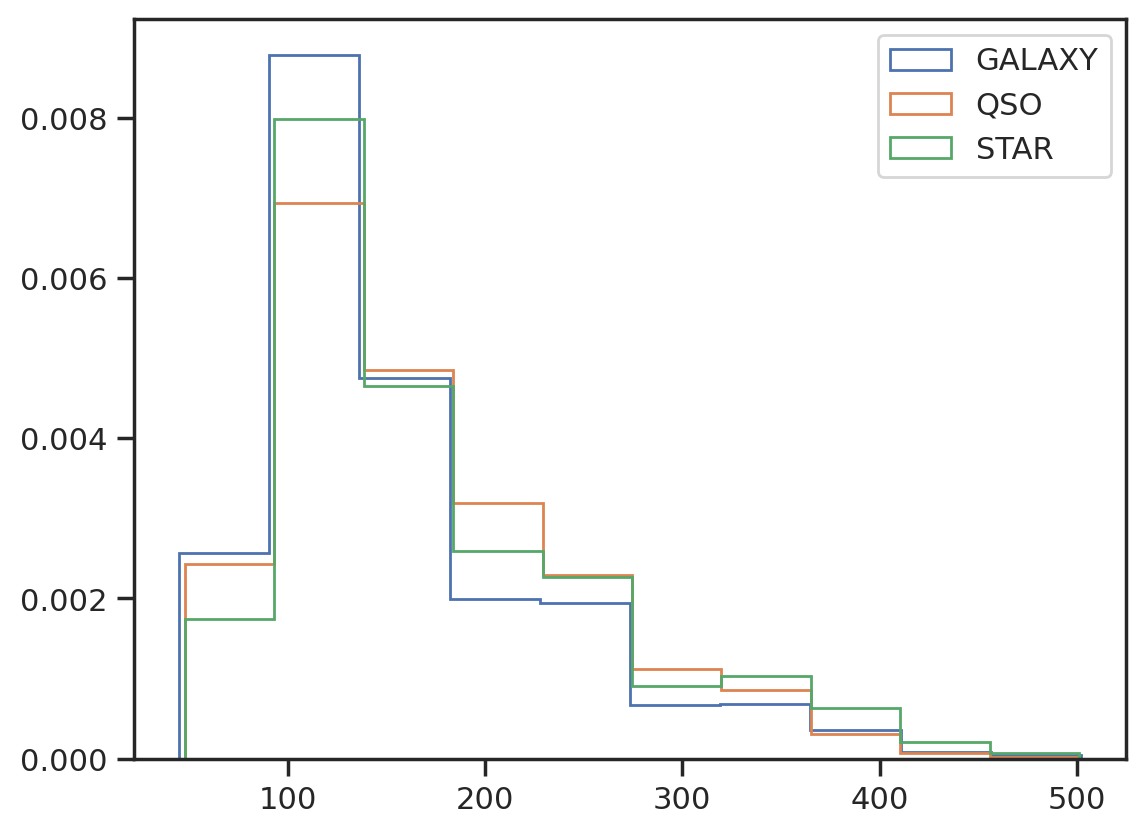

In [39]:
# Number of observations per class
sdss_x_ztf_features['n_obs'] = [len(lc['mjd']) for lc in ztf_x_sdss_reduced]

for cls in ['GALAXY', 'QSO', 'STAR']:
    tmp = sdss_x_ztf_features.loc[sdss_x_ztf_features['CLASS'] == cls]
    plt.hist(tmp['n_obs'], label=cls, density=True, histtype='step')

plt.legend()

# Retrain tensorflow model

In [26]:
def build_model(encoder, n_classes, maxlen, train_astromer=False, lr=1e-3):
    serie  = Input(shape=(maxlen, 1), batch_size=None, name='input')
    times  = Input(shape=(maxlen, 1), batch_size=None, name='times')
    mask   = Input(shape=(maxlen, 1), batch_size=None, name='mask')

    placeholder = {'input':serie,
                   'mask_in':mask,
                   'times':times}

    encoder.trainable = train_astromer
    
    mask = 1.-placeholder['mask_in']
    x = encoder(placeholder, training=True)
    x = x * mask
    x = tf.reduce_sum(x, 1)/tf.reduce_sum(mask, 1)

    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = LayerNormalization()(x)
    x = Dense(n_classes)(x)
    
    classifier = Model(inputs=placeholder, outputs=x, name="FCATT")
    
    classifier.compile(loss=CategoricalCrossentropy(from_logits=True), 
                       metrics=['accuracy'],
                       optimizer=Adam(lr))
    return classifier

#     bool_mask = tf.logical_not(tf.cast(encoder.input['mask_in'], tf.bool))

#     x = encoder(encoder.input)
#     x = tf.reshape(x, [-1, maxlen, encoder.output.shape[-1]])
#     x = LayerNormalization()(x)

#     units = 32
#     dropout = 0.1
#     x = LSTM(units, return_sequences=True,
#              dropout=dropout, name='RNN_0')(x, mask=bool_mask)
#     x = LayerNormalization()(x)
#     x = LSTM(units, return_sequences=True,
#              dropout=dropout, name='RNN_1')(x, mask=bool_mask)
#     x = LayerNormalization()(x)
#     x = Dense(num_classes, name='FCN')(x)

#     return Model(inputs=encoder.input, outputs=x, name='RNNCLF')

def get_lstm_no_attention(units, num_classes, maxlen, dropout=0.5):
    ''' LSTM + LSTM + FC'''

    serie  = Input(shape=(maxlen, 1),
                  batch_size=None,
                  name='input')
    times  = Input(shape=(maxlen, 1),
                  batch_size=None,
                  name='times')

    mask   = Input(shape=(maxlen, 1),
                  batch_size=None,
                  name='mask')
    length = Input(shape=(maxlen,),
                  batch_size=None,
                  dtype=tf.int32,
                  name='length')

    placeholder = {'input': serie,
                   'mask_in': mask,
                   'times': times,
                   'length': length}

    bool_mask = tf.logical_not(tf.cast(placeholder['mask_in'], tf.bool))

    x = tf.concat([placeholder['times'], placeholder['input']], 2)

    x = LSTM(units, return_sequences=True,
             dropout=dropout, name='RNN_0')(x, mask=bool_mask)
    x = LayerNormalization(axis=1)(x)
    x = LSTM(units, return_sequences=True,
             dropout=dropout, name='RNN_1')(x, mask=bool_mask)
    x = LayerNormalization(axis=1)(x)
    x = Dense(num_classes, name='FCN')(x)

    return Model(inputs=placeholder, outputs=x, name='RNNCLF')

In [27]:
astromer = SingleBandEncoder()
astromer = astromer.from_pretraining('ztfg')

# Load weights finetuned to our data
astromer.load_weights(os.path.join(PROJECT_PATH, 'outputs/models/astromer_g'))

[INFO] Weights already downloaded


In [28]:
astromer_encoder = astromer.model.get_layer('encoder')

classifier = build_model(
    astromer_encoder, 
    len(np.unique(y)), 
    maxlen=astromer.maxlen,
    train_astromer=True,
)

In [29]:
# Training params
batch_size = 32
epochs = 100
early_stopping = 10

In [30]:
train_batches = make_pretraining(
    X_train, labels=y_train, n_classes=3, batch_size=batch_size, shuffle=True,
    sampling=False, max_obs=200, msk_frac=0., rnd_frac=0., same_frac=0., repeat=1,
)

validation_batches = make_pretraining(
    X_val, labels=y_val, n_classes=3, batch_size=batch_size, shuffle=True,
    sampling=False, max_obs=200, msk_frac=0., rnd_frac=0., same_frac=0., repeat=1,
)

history = classifier.fit(
    train_batches, validation_data=validation_batches, epochs=epochs, 
    callbacks=[EarlyStopping(patience=early_stopping)],
    # steps_per_epoch=len(X_train) // batch_size,
    # validation_steps=len(X_val) // batch_size,
)

[INFO] Loading Numpy
[INFO] Loading Numpy
Epoch 1/100


2023-08-10 13:47:07.641063: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


      9/Unknown - 4s 63ms/step - loss: 2.4378 - accuracy: 0.4479

KeyboardInterrupt: 

In [ ]:
y_pred = classifier.predict(validation_batches)
y_pred = np.argmax(y_pred, 1)

In [ ]:
# y_test = np.argmax(y_test, 1)
y_test = np.concatenate([np.argmax(y, 1) for _, y in validation_batches])